In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from dask.distributed import Client

client = Client(processes=True)
client

Client Scheduler: tcp://127.0.0.1:53308 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [2]:
epoch_key = 'remy', 35, 2
exclude_interneuron_spikes = True

In [8]:
import logging
import os
import sys
from argparse import ArgumentParser
from signal import SIGUSR1, SIGUSR2, signal
from subprocess import PIPE, run

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from loren_frank_data_processing import save_xarray
from loren_frank_data_processing.position import (EDGE_ORDER, EDGE_SPACING,
                                                  make_track_graph)
from replay_trajectory_classification import (ClusterlessClassifier,
                                              SortedSpikesClassifier)
from scipy.ndimage import label
from src.analysis import (get_place_field_max, get_replay_info,
                          reshape_to_segments)
from src.load_data import load_data
from src.parameters import (ANIMALS, FIGURE_DIR, PROBABILITY_THRESHOLD,
                            PROCESSED_DATA_DIR, SAMPLING_FREQUENCY,
                            TRANSITION_TO_CATEGORY,
                            continuous_transition_types, discrete_diag,
                            knot_spacing, model, model_kwargs, movement_var,
                            place_bin_size, replay_speed, spike_model_penalty)
from src.visualization import plot_ripple_decode_1D
from tqdm.auto import tqdm

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [5]:
animal, day, epoch = epoch_key
data_type, dim = 'clusterless', '1D'

logging.info('Loading data...')
data = load_data(epoch_key,
                 exclude_interneuron_spikes=exclude_interneuron_spikes)

26-Jan-21 13:22:47 Loading data...
26-Jan-21 13:22:48 Loading position info...
26-Jan-21 13:34:11 Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
26-Jan-21 13:34:11 No DIO file found, using distance from well to segment trials
26-Jan-21 13:34:13 Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
26-Jan-21 13:34:13 No DIO file found, inferring correct inbound/outbound from task rules
26-Jan-21 13:34:39 Loading spikes...
26-Jan-21 13:35:22 Loading multiunit...
26-Jan-21 13:36:11 Finding ripple times...
26-Jan-21 14:10:02 Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
26-Jan-21 14:10:02 No DIO file found, using distance from well to segment trials
26-Jan-21 14:10:05 Failed to load file: /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
26-Jan-21 14:10:05 No DIO file fou

In [6]:
client.close()

In [7]:
is_training = data['position_info'].speed > 4
position = data['position_info'].loc[:, 'linear_position']
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

In [10]:
if not exclude_interneuron_spikes:
    model_name = os.path.join(
        PROCESSED_DATA_DIR,
        f'{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl')
    group = f'/{data_type}/{dim}/classifier/ripples/'
    epoch_identifier = f'{animal}_{day:02d}_{epoch:02d}_{data_type}_{dim}'
else:
    logging.info('Excluding interneuron spikes...')
    model_name = os.path.join(
        PROCESSED_DATA_DIR,
        f'{animal}_{day:02}_{epoch:02}_{data_type}_{dim}'
        '_no_interneuron_model.pkl')
    group = f'/{data_type}/{dim}/no_interneuron/classifier/ripples/'
    epoch_identifier = (f'{animal}_{day:02d}_{epoch:02d}_{data_type}_{dim}'
                        '_no_interneuron')

try:
    results = xr.open_dataset(
        os.path.join(
            PROCESSED_DATA_DIR, f'{animal}_{day:02}_{epoch:02}.nc'),
        group=group)
    logging.info('Found existing results. Loading...')
    ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]
    spikes = (((data['multiunit'].sum('features') > 0) * 1.0)
              .to_dataframe(name='spikes').unstack())
    spikes.columns = data['tetrode_info'].tetrode_id
    ripple_spikes = reshape_to_segments(spikes, ripple_times)
    classifier = ClusterlessClassifier.load_model(model_name)
    logging.info(classifier)
except (FileNotFoundError, OSError):
    logging.info('Fitting classifier...')
    classifier = ClusterlessClassifier(
        place_bin_size=place_bin_size, movement_var=movement_var,
        replay_speed=replay_speed,
        discrete_transition_diag=discrete_diag,
        continuous_transition_types=continuous_transition_types,
        model=model, model_kwargs=model_kwargs).fit(
            position, data['multiunit'], is_training=is_training,
            track_graph=track_graph, center_well_id=center_well_id,
            edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING)
    classifier.save_model(model_name)
    logging.info(classifier)

    # Decode
    is_test = ~is_training

    test_groups = pd.DataFrame(
        {'test_groups': label(is_test.values)[0]}, index=is_test.index)
    immobility_results = []
    for _, df in tqdm(test_groups.loc[is_test].groupby('test_groups'),
                      desc='immobility'):
        start_time, end_time = df.iloc[0].name, df.iloc[-1].name
        test_multiunit = data['multiunit'].sel(
            time=slice(start_time, end_time))
        immobility_results.append(
            classifier.predict(test_multiunit, time=test_multiunit.time))

    immobility_results = xr.concat(immobility_results, dim='time')

    results = [(immobility_results
                .sel(time=slice(df.start_time, df.end_time))
                .assign_coords(time=lambda ds: ds.time - ds.time[0]))
               for _, df in data['ripple_times'].iterrows()]

    results = (xr.concat(results, dim=data['ripple_times'].index)
               .assign_coords(state=lambda ds: ds.state.to_index()
                              .map(TRANSITION_TO_CATEGORY)))

    ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]
    spikes = ((((~np.isnan(data['multiunit'])).sum('features') > 0) * 1.0)
              .to_dataframe(name='spikes').unstack())
    spikes.columns = data['tetrode_info'].tetrode_id
    ripple_spikes = reshape_to_segments(spikes, ripple_times)

    logging.info('Saving results...')
    save_xarray(PROCESSED_DATA_DIR, epoch_key,
                results.drop(['likelihood', 'causal_posterior']),
                group=group)

26-Jan-21 14:15:18 Excluding interneuron spikes...
26-Jan-21 14:15:18 Found existing results. Loading...
26-Jan-21 14:15:32 ClusterlessClassifier(discrete_transition_diag=0.98, movement_var=6.0,
                      occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                      occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      place_bin_size=3.0, replay_speed=1)


In [13]:
logging.info('Saving replay_info...')
replay_info = get_replay_info(
    results, spikes, data['ripple_times'], data['position_info'],
    track_graph, SAMPLING_FREQUENCY, PROBABILITY_THRESHOLD, epoch_key,
    classifier, data["ripple_consensus_trace_zscore"])

26-Jan-21 14:19:48 Saving replay_info...


IndexError: index 0 is out of bounds for axis 0 with size 0

In [14]:
%debug

> /Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/numpy/lib/function_base.py(997)gradient()
    995             # if distances are constant reduce to the scalar case
    996             # since it brings a consistent speedup
--> 997             if (diffx == diffx[0]).all():
    998                 diffx = diffx[0]
    999             dx[i] = diffx



ipdb>  u


> <__array_function__ internals>(6)gradient()



ipdb>  u


> /Users/edeno/Documents/GitHub/replay_trajectory_paper/src/analysis.py(215)get_ripple_replay_info()
    213     map_estimate = map_estimate.squeeze()
    214     replay_speed = np.abs(np.gradient(
--> 215         replay_distance_from_center_well, time))
    216     SMOOTH_SIGMA = 0.0025
    217     replay_speed = gaussian_smooth(



ipdb>  ripple


Pandas(Index=1, start_time=Timedelta('0 days 00:27:03.728866'), end_time=Timedelta('0 days 00:27:03.782866'), duration=0.054000000000000006)


ipdb>  q


In [55]:
ripple_number = 20

result = (results
          .sel(ripple_number=ripple_number)
          .dropna('time', how='all')
          .assign_coords(
              time=lambda ds: ds.time / np.timedelta64(1, 's')))

result.acausal_posterior.shape

(0, 3, 109)

In [42]:
start_time, end_time = data['ripple_times'].loc[1].start_time, data['ripple_times'].loc[1].end_time

data['multiunit'].sel(time=slice(start_time, end_time), tetrodes=21)

<xarray.DataArray (time: 27, features: 4)>
array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]])
Coordinates:
  * time      (time) timedelta64[ns] 00:27:03.730200 ... 00:27:03.782200
  * features  (features) object 'channel_1_max' ... 'channel_4_max'

In [10]:
import xarray as xr
from src.parameters import PROCESSED_DATA_DIR
import os

epoch_key = 'remy', 37, 4

animal, day, epoch = epoch_key
data_type, dim = 'clusterless', '1D'


group = f'/{data_type}/{dim}/no_interneuron/classifier/ripples/'

results = xr.open_dataset(
    os.path.join(
        PROCESSED_DATA_DIR, f'{animal}_{day:02}_{epoch:02}.nc'),
    group=group, autoclose=True)

In [12]:
import numpy as np


ripple_number = 1

result = (results
          .sel(ripple_number=ripple_number)
          .dropna('time', how='all')
          .assign_coords(
              time=lambda ds: ds.time / np.timedelta64(1, 's')))

result.acausal_posterior.shape

(0, 3, 109)

In [7]:
results

<xarray.Dataset>
Dimensions:            (position: 109, ripple_number: 315, state: 3, time: 160)
Coordinates:
  * state              (state) object 'Continuous' 'Fragmented' 'Hover'
  * position           (position) float64 1.464 4.391 7.319 ... 338.4 341.3
  * time               (time) timedelta64[ns] 00:00:00 ... 00:00:00.318000
  * ripple_number      (ripple_number) int64 1 2 3 4 5 6 ... 311 312 313 314 315
Data variables:
    acausal_posterior  (ripple_number, time, state, position) float64 ...

In [29]:
from src.parameters import _BRAIN_AREAS, ANIMALS
import pandas as pd
import numpy as np
from loren_frank_data_processing import (
    get_trial_time, make_tetrode_dataframe, get_all_multiunit_indicators)

epoch_key = 'remy', 35, 2
brain_areas = None

if brain_areas is None:
    brain_areas = _BRAIN_AREAS

time = get_trial_time(epoch_key, ANIMALS)
time = (pd.Series(np.ones_like(time, dtype=np.float), index=time)
        .resample('2ms').mean()
        .index)

def _time_function(*args, **kwargs):
    return time

tetrode_info = make_tetrode_dataframe(ANIMALS, epoch_key=epoch_key)
is_brain_areas = (
    tetrode_info.area.astype(str).str.upper().isin(brain_areas))
tetrode_info = tetrode_info.loc[is_brain_areas]
multiunit = (get_all_multiunit_indicators(
    tetrode_info.index, ANIMALS, _time_function)
    .reindex({'time': time}))

if epoch_key[0] == "remy":
    # Remy features aren't extracted using matclust so in different format.
    features = multiunit.features.values
    features[-1] = "max_width"  # last feature is max_width
    multiunit["features"] = features
    # Convert to milliseconds
    multiunit.loc[dict(features='max_width')] *= 1000
else:
    # Convert to milliseconds
    multiunit.loc[dict(features='max_width')] /= 10

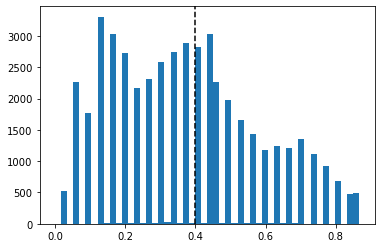

In [30]:
import matplotlib.pyplot as plt


tetrode_ind = 11
plt.hist(multiunit.isel(tetrodes=tetrode_ind).sel(features='max_width').dropna('time'), bins=50)

INTERNEURON_SPIKE_WIDTH_MAX = 0.4 # ms

plt.axvline(INTERNEURON_SPIKE_WIDTH_MAX, zorder=10, color='black', linestyle='--')

In [31]:
multiunit.isel(tetrodes=tetrode_ind).sel(features='max_width').dropna('time')

<xarray.DataArray (time: 48455)>
array([0.43333333, 0.46666667, 0.23333333, ..., 0.13333333, 0.16666667,
       0.16666667])
Coordinates:
  * time      (time) timedelta64[ns] 00:27:02.550200 ... 00:47:34.676200
    features  <U9 'max_width'

In [41]:
from src.parameters import _BRAIN_AREAS, ANIMALS
import pandas as pd
import numpy as np
from loren_frank_data_processing import (
    get_trial_time, make_tetrode_dataframe, get_all_multiunit_indicators)

epoch_key = 'bon', 3, 2
brain_areas = None

if brain_areas is None:
    brain_areas = _BRAIN_AREAS

time = get_trial_time(epoch_key, ANIMALS)
time = (pd.Series(np.ones_like(time, dtype=np.float), index=time)
        .resample('2ms').mean()
        .index)

def _time_function(*args, **kwargs):
    return time

tetrode_info = make_tetrode_dataframe(ANIMALS, epoch_key=epoch_key)
is_brain_areas = (
    tetrode_info.area.astype(str).str.upper().isin(brain_areas))
tetrode_info = tetrode_info.loc[is_brain_areas]
multiunit = (get_all_multiunit_indicators(
    tetrode_info.index, ANIMALS, _time_function)
    .reindex({'time': time}))

if epoch_key[0] == "remy":
    # Remy features aren't extracted using matclust so in different format.
    features = multiunit.features.values
    features[-1] = "max_width"  # last feature is max_width
    multiunit["features"] = features
    # Convert to milliseconds
    multiunit.loc[dict(features='max_width')] *= 1000
else:
    # Convert to milliseconds
    multiunit.loc[dict(features='max_width')] /= 1

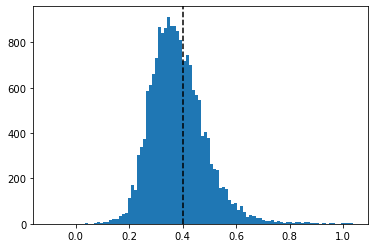

In [73]:
import matplotlib.pyplot as plt


INTERNEURON_SPIKE_WIDTH_MAX = 0.400 # ms

tetrode_ind = 9
plt.hist(1000 * (multiunit.sel(features='max_width').isel(tetrodes=tetrode_ind).dropna('time')) / 30000, bins=100);
plt.axvline(INTERNEURON_SPIKE_WIDTH_MAX, zorder=10, color='black', linestyle='--')

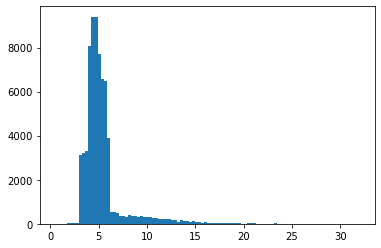

In [54]:
plt.hist(multiunit.sel(features='max_width').isel(tetrodes=tetrode_ind).dropna('time'), bins=100);

In [62]:
(1000 * np.round(multiunit.sel(features='max_width').isel(tetrodes=tetrode_ind).dropna('time')) / 30000 < 0.4).mean()

<xarray.DataArray ()>
array(0.87642999)
Coordinates:
    features  <U17 'max_width'

In [71]:
multiunit.sel(features='max_width').isel(tetrodes=tetrode_ind).dropna('time')

<xarray.DataArray (time: 18196)>
array([12.08584481,  6.61892906,  9.70135562, ...,  7.22951135,
        9.15283663,  8.10893397])
Coordinates:
  * time      (time) timedelta64[ns] 01:02:09.009700 ... 01:17:39.907700
    features  <U17 'max_width'

In [72]:
np.round(multiunit.sel(features='max_width').isel(tetrodes=tetrode_ind).dropna('time'))

<xarray.DataArray (time: 18196)>
array([12.,  7., 10., ...,  7.,  9.,  8.])
Coordinates:
  * time      (time) timedelta64[ns] 01:02:09.009700 ... 01:17:39.907700
    features  <U17 'max_width'

In [75]:
overwrite = False

try:
    if overwrite:
        raise FileNotFoundError
    print('blah')
except FileNotFoundError:
    print('blah2')

blah
